In [90]:
# necessary libraries for prediciton
import utils
import os
import pandas as pd
import numpy as np
import pprint
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.combine import SMOTETomek

from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

In [91]:
pd.set_option('display.max_columns', 200)
os.makedirs('images', exist_ok=True)
SEED = 42

# Useful Functions

In [92]:
def pretty_matrix(matrix, row_label, col_label):
    """Pretty print of the given matrix """

    # Restraining labels that are too big
    row_label = [el[:10] + '..' if len(el) > 10 else el
                for el in row_label]
    col_label = [el[:10] + '..' if len(el) > 10 else el
                for el in col_label]

    # Stringfying everything & Joining top label
    s_matrix = [list([" "] + (col_label))] + \
               [[row_label[row_idx]] + \
                [str(e) for e in row] for row_idx, row in enumerate(matrix)]

    # Length of each matrix column
    len_s = [max(map(len, col)) for col in zip(*s_matrix)]

    # Cell formatation
    formatation = '\t'.join('{{:{}}}'.format(x) for x in len_s)

    # Apply cell formation to each matrix element
    pretty_mat = [formatation.format(*row) for row in s_matrix]

    # Print Pretty Matrix
    print('\n'.join(pretty_mat))


def display_confusion_matrix(values):
    '''Display the given array as a confusion matrix'''
    pretty_matrix([values[0:2], values[2:4]],
                  ['Actual NO', 'Actual YES'],
                  ['Predic NO', 'Predic YES'])

In [93]:
def plot_roc_auc(fpr, tpr, roc_auc):
    '''Plot the ROC-AUC curve'''
    fig, ax = plt.subplots()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'w--')
    plt.xlim([-0.02, 1.02])
    plt.ylim([0, 1])
    ax.fill_between(fpr, 0, tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [94]:
def visualize_tree(classifier, name):
    '''Visualize the given classifier,
    by creating a .png with a given name.'''
    dot_name = name + '.dot'
    png_name = name + '.png'

    export_graphviz(classifier,
                    out_file=dot_name, 
                    feature_names = list(X.columns),
                    class_names = 'status',
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz installed)
    call(['dot', '-Tpng', dot_name, '-o', png_name, '-Gdpi=600'])
    call(['rm', dot_name])

    # Display 
    Image('tree.png')

In [95]:
def normalize_columns(df, columns):
    '''Normalize the given columns for range between [0, 1]'''
    for col in columns:
        col_min = df[col].min()
        col_max =  df[col].max()
        
        df[col] = (df[col] - col_min)/\
                    (col_max - col_min)
        
def normalize_df(df):
    '''Normalize all columns of the given df'''
    normalize_columns(df, df.columns)

In [96]:
def apply_PCA(df, variance_val=0.95, debug=True):
    '''Apply the PCA algorithm to given dataframe,
    using the given variance val to trim the df'''
    # Necessary to normalize all data to use PCA
    scaler=StandardScaler()
    X_scaled=scaler.fit_transform(df)

    # PCA - keep, by default mode, 90% variance
    pca = PCA(variance_val)    
    pca.fit(X_scaled)
    X_pca = pca.transform(X_scaled)

    if debug:
        ex_variance=np.var(X_pca,axis=0)
        ex_variance_ratio = ex_variance/np.sum(ex_variance)
        print(' > Impact in total variance of each generated feature by PCA:')
        print(ex_variance_ratio)

    principal_df = pd.DataFrame(data = X_pca, index = df.reset_index()['loan_id'])
    
    return (principal_df, pca)

In [97]:
def apply_sampling(algorithm, oversample, undersample):
    '''Apply sampling according to the control flags'''
    # Applying sampling techniques
    pipeline = Pipeline([
        ('classification', algorithm)
    ])
    
    if oversample:
        if undersample:
            pipeline = Pipeline([
                ('sampling', SMOTETomek(random_state = SEED)),
                ('classification', algorithm)
            ])
        else:
            pipeline = Pipeline([
                ('sampling', SMOTE(random_state = SEED)),
                ('classification', algorithm)
            ])
    elif undersample:
        pipeline = Pipeline([
        ('sampling', NeighbourhoodCleaningRule(random_state = SEED)),
        ('classification', algorithm)
    ])
        
    return pipeline

In [98]:
def auc_scorer(y_true, y_pred):
    '''Scorer of Area Under Curve value'''
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)
    return metrics.auc(fpr, tpr)

# Prediction Algorithms

* Logistic Regression
* Decision Tree
* Random Forest
* Gradient Boosting

In [99]:
def create_LR():
    '''Create a Logistic Regression model'''
    return LogisticRegression(random_state=SEED)

In [100]:
def create_DT():
    '''Create a new Decision Tree'''
    return DecisionTreeClassifier(random_state=SEED)

In [101]:
def create_RF():
    '''Create a new Ranfom Forest model'''
    return RandomForestClassifier(random_state=SEED)

In [102]:
def create_GB():
    '''Create a new Gradient Boosting model'''
    return GradientBoostingClassifier(random_state=SEED)

# Prediction

* Predictions are done in this notebook.
* It is also useful to compare how serveral algorithms perform against one another.

In [103]:
# Useful Macros
K_FOLD_NUM_SPLITS = 5
USE_PCA = False
UNDERSAMPLE = False
OVERSAMPLE = False

# Pretty printer
pp = pprint.PrettyPrinter(indent=4)

In [104]:
dataset =  utils.read_csv_to_df('dataset/preprocessed_data.csv')

dataset = dataset.set_index('loan_id')
display(dataset)
# Normalizing dataset
print(' > Dataset after normalization')
normalize_df(dataset)
display(dataset)

,date,amount,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,CC,CC_mean,CC_sum,CC_max,CC_std,CC_min,CAB,CAB_mean,CAB_sum,CAB_max,CAB_std,CAB_min,IC,IC_mean,IC_sum,IC_max,IC_std,IC_min,WC,WC_mean,WC_sum,WC_max,WC_std,WC_min,RAB,RAB_mean,RAB_sum,RAB_max,RAB_std,RAB_min,CCW,CCW_mean,CCW_sum,CCW_max,CCW_std,CCW_min,mean_trans_profit,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC,owner_count,owner_gender,card_type,has_card,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,criminality_growth,unemploymant_growth,account_age_on_loan,days_since_last_transaction,owner_age_on_loan,max_value_in_account_to_loan_ratio,last_value_in_account_to_loan_ratio,account_age_months,trans_per_month,credit_per_month,withdrawal_per_month,salary_from_month_records,withdrawal_to_credit_month_ratio,expected_month_income,actual_month_income,expected_income_to_payments_ratio,actual_income_to_payments_ratio,ratio_actual_salary_to_expected,log_credit_min,log_sanctions_std,log_CAB_sum,log_CAB_mean,log_max_value_in_account_to_loan_ratio,log_criminality_growth,status
loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5314,741830400000000000,96396,8033,2,12250.000000,20100.0,1100.0,8330.866301,20100.0,3300.0,1.0,5025.000000,4,9900.0,1100.0,3774.806838,0.000000,0.0,0.0,0.0,0.000000,5025.000000,20100.0,4,3774.806838,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,5025.000000,20100.0,9900.0,3774.806838,1100.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5025.000000,1.000000,0.000000,19000.0,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1,1,-1.0,-1.0,7,94812,15,13,8,2,10,0.818,9650,0.100,-0.001909,0.29,105,15,45.986301,0.208515,0.208515,3.500000,1.142857,1435.714286,0.000000,5025.000000,0.000000,804.166667,5025.000000,0.100108,0.625545,6.248705,7.003247,0.0,0.000000,0.000000,0.113178,0.034255,-1
5316,742348800000000000,165960,4610,1,52083.859459,120512.8,700.0,29122.059454,52208.9,-3419.0,1.0,13523.158824,17,36574.0,2.9,13998.092225,-8884.240000,20.0,-14.6,-54300.0,14074.800608,2608.833333,62612.0,24,22249.103350,-14.6,-43.8,3.0,-956.0,-2868.0,3.0,0.0,0.0,0.0,0.0,12,19087.583333,229051.0,36574.0,13044.711945,700.0,0.0,0.000000,0.0,0.0,0.000000,0.0,5.0,168.540000,842.7,303.4,114.790213,2.9,12.0,-13018.816667,-156225.8,-14.6,17151.944816,-54300.0,8.0,-2682.375000,-21459.0,-956.0,1462.736373,-4167.0,0.0,0.0,0.0,0.0,0.0,0.0,4638.918824,0.459459,0.540541,119812.8,0.324324,0.000000,0.324324,0.216216,0.0,0.135135,1,0,-1.0,-1.0,2,112709,48,20,7,3,10,0.735,8369,0.117,-0.002094,0.52,148,2,24.986301,0.726156,0.314587,4.933333,7.500000,2741.180843,-1800.859459,4638.918824,-0.656965,350.166667,4291.668824,0.075958,0.930948,12.256075,1.131402,0.0,0.000000,0.000000,0.493154,0.034077,1
6863,743817600000000000,127080,2118,1,30060.954167,49590.4,800.0,11520.184451,20272.8,-12000.0,1.0,5009.733333,15,19065.0,48.6,6801.234716,-6097.000000,9.0,-66.0,-14800.0,5390.565972,1966.714286,27534.0,14,10647.755108,0.0,0.0,0.0,-66.0,-66.0,1.0,0.0,0.0,0.0,0.0,2,2250.000000,4500.0,3700.0,2050.609665,800.0,5.0,13981.000000,69905.0,19065.0,2842.042399,12710.0,8.0,92.625000,741.0,139.8,32.231872,48.6,6.0

 > Dataset after normalization


,date,amount,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,CC,CC_mean,CC_sum,CC_max,CC_std,CC_min,CAB,CAB_mean,CAB_sum,CAB_max,CAB_std,CAB_min,IC,IC_mean,IC_sum,IC_max,IC_std,IC_min,WC,WC_mean,WC_sum,WC_max,WC_std,WC_min,RAB,RAB_mean,RAB_sum,RAB_max,RAB_std,RAB_min,CCW,CCW_mean,CCW_sum,CCW_max,CCW_std,CCW_min,mean_trans_profit,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC,owner_count,owner_gender,card_type,has_card,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,criminality_growth,unemploymant_growth,account_age_on_loan,days_since_last_transaction,owner_age_on_loan,max_value_in_account_to_loan_ratio,last_value_in_account_to_loan_ratio,account_age_months,trans_per_month,credit_per_month,withdrawal_per_month,salary_from_month_records,withdrawal_to_credit_month_ratio,expected_month_income,actual_month_income,expected_income_to_payments_ratio,actual_income_to_payments_ratio,ratio_actual_salary_to_expected,log_credit_min,log_sanctions_std,log_CAB_sum,log_CAB_mean,log_max_value_in_account_to_loan_ratio,log_criminality_growth,status
loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5314,0.000000,0.171345,0.823266,1.0,0.000000,0.000000,0.273848,0.097263,0.128125,0.517311,1.0,0.100131,0.0000,0.025633,1.000000,0.049126,1.000000,0.000000,1.000000,1.000000,0.000000,0.565940,0.094611,0.000000,0.014891,1.000,1.0000,0.000000,1.000000,1.000000,0.000000,1.0,1.0,0.0,0.0,0.061224,0.159347,0.014823,0.194857,0.145173,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.0,1.0,1.0,1.0,0.0,1.0,0.624874,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,1.000000,0.044738,0.099338,0.185714,0.40,0.4,0.9,0.724660,0.347551,0.220930,0.727478,0.143014,0.000000,0.666667,0.685425,0.012673,0.038349,0.000000,0.002641,0.250808,1.000000,0.624874,1.000000,0.850687,0.641549,0.170062,0.299329,0.386299,1.000000,0.0,0.000000,0.000000,0.048220,0.732083,0.0
5316,0.004721,0.301732,0.457951,0.5,0.622572,0.577716,0.249638,0.792831,0.377597,0.447516,1.0,0.449603,0.1625,0.427822,0.001910,0.452368,0.700270,0.141844,0.999274,0.163328,0.689218,0.297839,0.250351,0.148148,0.496622,0.854,0.9781,0.136364,0.895118,0.980702,0.157895,1.0,1.0,0.0,0.0,0.224490,0.623768,0.170470,0.730695,0.501677,0.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087719,0.503220,0.085852,0.652473,0.604206,0.013339,0.118812,0.602681,0.878174,0.999274,0.815947,0.163328,0.117647,0.817811,0.918812,0.935068,0.255275,0.716973,0.0,1.0,1.0,1.0,0.0,1.0,0.610923,0.286947,0.713053,0.578022,0.319696,0.000000,0.496415,0.578378,0.0,0.270270,0.0,0.0,0.0,0.0,0.285714,0.060138,0.317881,0.285714,0.35,0.6,0.9,0.599092,0.058452,0.418605,0.723619,0.193619,0.072758,0.047619,0.241205,0.067419,0.060818,0.072758,0.718487,0.510539,0.684069,0.610923,0.754242,0.569311,0.614343,0.157441,0.314285,0.401468,0.161554,0.0,0.000000,0.000000,0.210111,0.728266,1.0
6863,0.018096,0.228857,0.191996,0.5,0.278371,0.169670,0.255691,0.203961,0.129468,0.358378,1.0,0.099503,0.1375,0.163822,0.043486,0.168499,0.794304,0.063830,0.996716,0.771

In [105]:
STATUS_COL = dataset.columns.get_loc("status")

In [106]:
# Setting X and Y
X = dataset.iloc[:, 0:STATUS_COL]
y = dataset.iloc[:, [STATUS_COL]]
display(X.head())

if USE_PCA:
    print(' > Applying PCA to X_train:')
    X, pca = apply_PCA(X, debug=True)
    display(X.head())

,date,amount,payments,frequency,balance_mean,balance_max,balance_min,balance_std,last_balance,last_trans,reached_negative_balance,credit_mean,credit_count,credit_max,credit_min,credit_std,withdrawal_mean,withdrawal_count,withdrawal_max,withdrawal_min,withdrawal_std,unknown_mean,unknown_sum,unknown_count,unknown_std,payment_statement_mean,payment_statement_sum,payment_statement_count,ins_payment_mean,ins_payment_sum,ins_payment_count,sanctions_mean,sanctions_sum,sanctions_count,sanctions_std,CC,CC_mean,CC_sum,CC_max,CC_std,CC_min,CAB,CAB_mean,CAB_sum,CAB_max,CAB_std,CAB_min,IC,IC_mean,IC_sum,IC_max,IC_std,IC_min,WC,WC_mean,WC_sum,WC_max,WC_std,WC_min,RAB,RAB_mean,RAB_sum,RAB_max,RAB_std,RAB_min,CCW,CCW_mean,CCW_sum,CCW_max,CCW_std,CCW_min,mean_trans_profit,credit_ratio,withdrawal_ratio,balance_range,ratio_CC,ratio_CAB,ratio_WC,ratio_RAB,ratio_CCW,ratio_IC,owner_count,owner_gender,card_type,has_card,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,ratio entrepeneurs,criminality_growth,unemploymant_growth,account_age_on_loan,days_since_last_transaction,owner_age_on_loan,max_value_in_account_to_loan_ratio,last_value_in_account_to_loan_ratio,account_age_months,trans_per_month,credit_per_month,withdrawal_per_month,salary_from_month_records,withdrawal_to_credit_month_ratio,expected_month_income,actual_month_income,expected_income_to_payments_ratio,actual_income_to_payments_ratio,ratio_actual_salary_to_expected,log_credit_min,log_sanctions_std,log_CAB_sum,log_CAB_mean,log_max_value_in_account_to_loan_ratio,log_criminality_growth
loan_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5314,0.000000,0.171345,0.823266,1.0,0.000000,0.000000,0.273848,0.097263,0.128125,0.517311,1.0,0.100131,0.0000,0.025633,1.000000,0.049126,1.000000,0.000000,1.000000,1.000000,0.000000,0.565940,0.094611,0.000000,0.014891,1.000,1.0000,0.000000,1.000000,1.000000,0.000000,1.0,1.0,0.0,0.0,0.061224,0.159347,0.014823,0.194857,0.145173,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.0,1.0,1.0,1.0,0.0,1.0,0.624874,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,1.000000,0.044738,0.099338,0.185714,0.40,0.4,0.9,0.724660,0.347551,0.220930,0.727478,0.143014,0.000000,0.666667,0.685425,0.012673,0.038349,0.000000,0.002641,0.250808,1.000000,0.624874,1.000000,0.850687,0.641549,0.170062,0.299329,0.386299,1.000000,0.0,0.000000,0.000000,0.048220,0.732083
5316,0.004721,0.301732,0.457951,0.5,0.622572,0.577716,0.249638,0.792831,0.377597,0.447516,1.0,0.449603,0.1625,0.427822,0.001910,0.452368,0.700270,0.141844,0.999274,0.163328,0.689218,0.297839,0.250351,0.148148,0.496622,0.854,0.9781,0.136364,0.895118,0.980702,0.157895,1.0,1.0,0.0,0.0,0.224490,0.623768,0.170470,0.730695,0.501677,0.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087719,0.503220,0.085852,0.652473,0.604206,0.013339,0.118812,0.602681,0.878174,0.999274,0.815947,0.163328,0.117647,0.817811,0.918812,0.935068,0.255275,0.716973,0.0,1.0,1.0,1.0,0.0,1.0,0.610923,0.286947,0.713053,0.578022,0.319696,0.000000,0.496415,0.578378,0.0,0.270270,0.0,0.0,0.0,0.0,0.285714,0.060138,0.317881,0.285714,0.35,0.6,0.9,0.599092,0.058452,0.418605,0.723619,0.193619,0.072758,0.047619,0.241205,0.067419,0.060818,0.072758,0.718487,0.510539,0.684069,0.610923,0.754242,0.569311,0.614343,0.157441,0.314285,0.401468,0.161554,0.0,0.000000,0.000000,0.210111,0.728266
6863,0.018096,0.228857,0.191996,0.5,0.278371,0.169670,0.255691,0.203961,0.129468,0.358378,1.0,0.099503,0.1375,0.163822,0.043486,0.168499,0.794304,0.063830,0.996716,0.771957,0.263967,0.2

# Hyper Parameter Tunning

## Random Search 1st to apporach the best solution, GridSearch to refine it

In [107]:
def getLogisticRegressionBest(X, y, debug=True):
    '''Get the Logistic Regression Hyper Parameters'''

    # Maximum number of levels in tree
    max_depth = [int(x) for x in range(2, 20, 4)]
    max_depth.append(None)

    # Create the random grid
    grid = {'classification__penalty': ['l2', 'none'],
            'classification__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
            'classification__solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            'classification__class_weight': ["balanced", None]}
    
    if debug:
        pp.pprint(grid)
    
    # Applying sampling techniques
    lr = apply_sampling(create_LR(), OVERSAMPLE, UNDERSAMPLE)

    # Using the grid search for best hyperparameters
    lr_grid = GridSearchCV(estimator = lr,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    lr_grid = lr_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', lr_grid.best_score_)
        print('Best Params: ', lr_grid.best_params_)
        
    # Return score, method & params tuple
    return (lr_grid.best_score_, 'Logistic Regression', lr_grid.best_params_)

In [108]:
def getDecisionTreeBest(X, y, debug=True):
    '''Get the Decision Tree Hyper Parameters'''

    # Maximum number of levels in tree
    max_depth = [int(x) for x in range(2, 16, 2)]
    max_depth.append(None)

    # Create the random grid
    grid = {'classification__criterion': ['gini', 'entropy'],
            'classification__splitter': ['best', 'random'],
            'classification__max_features': ['auto', 'sqrt'],
            'classification__max_depth': max_depth,
            'classification__min_samples_split':  [2, 4, 6, 8],
            'classification__min_samples_leaf':  [2, 4, 6],
            'classification__class_weight': ["balanced", None]}
    
    if debug:
        pp.pprint(grid)

    # Applying sampling techniques
    dt = apply_sampling(create_DT(), OVERSAMPLE, UNDERSAMPLE)

    # Using the grid search for best hyperparameters
    dt_grid = GridSearchCV(estimator = dt,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    dt_grid = dt_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', dt_grid.best_score_)
        print('Best Params: ', dt_grid.best_params_)
        
    # Return score, method & params tuple
    return (dt_grid.best_score_, 'Decision Tree', dt_grid.best_params_)

In [109]:
def getRandomForestBest(X, y, debug=True):
    '''Get the Random Forest Hyper Parameters'''

    # Maximum number of levels in tree
    max_depth = [int(x) for x in range(2, 16, 4)]
    max_depth.append(None)

    # Create the random grid
    grid = {'classification__n_estimators': [int(x) for x in range(2, 14, 2)],
            'classification__max_features': ['auto', 'sqrt'],
            'classification__max_depth': max_depth,
            'classification__criterion': ['gini', 'entropy'],
            'classification__min_samples_split':  [2, 4, 6, 8],
            'classification__min_samples_leaf':  [2, 4, 6],
            'classification__class_weight': ["balanced", "balanced_subsample", None]}
    
    if debug:
        pp.pprint(grid)
    
    # Applying sampling techniques
    rf = apply_sampling(create_RF(), OVERSAMPLE, UNDERSAMPLE)

    # Using the grid search for best hyperparameters
    rf_grid = GridSearchCV(estimator = rf,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    rf_grid = rf_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', rf_grid.best_score_)
        print('Best Params: ', rf_grid.best_params_)
        
    # Return score, method & params tuple
    return (rf_grid.best_score_, 'Random Forest', rf_grid.best_params_)

In [110]:
def getGradientBoostBest(X, y, debug=True):
    '''Get the Gradient Boost Hyper Parameters'''

    # Create the grid parameters
    grid = {'classification__n_estimators': [int(x) for x in range(2, 14, 2)],
            'classification__learning_rate': [0.1, 0.3, 0.5, 0.7],
            'classification__loss': ['deviance', 'exponential'],
            'classification__criterion': ['friedman_mse', 'mse', 'mae'],
            'classification__min_samples_split':  [4, 6, 8],
            'classification__min_samples_leaf':  [2, 4, 6]}
    
    if debug:
        pp.pprint(grid)

    # Applying sampling techniques
    gb = apply_sampling(create_GB(), OVERSAMPLE, UNDERSAMPLE)

    # Using the grid search for best hyperparameters
    gb_grid = GridSearchCV(estimator = gb,
                           param_grid = grid,
                           scoring=metrics.make_scorer(auc_scorer,
                                                       greater_is_better=True),
                           cv=K_FOLD_NUM_SPLITS,
                           verbose=2,
                           n_jobs = -1)

    # Fit the grid search model
    gb_grid = gb_grid.fit(X, y)
    
    if debug:
        print('Best Score: ', gb_grid.best_score_)
        print('Best Params: ', gb_grid.best_params_)
        
    # Return score, method & params tuple
    return (gb_grid.best_score_, 'Gradient Boosting', gb_grid.best_params_)

In [111]:
# Getting the best algorithm
algorithms = [getLogisticRegressionBest(X, y),
              getDecisionTreeBest(X, y),
              getRandomForestBest(X, y)]
              # getGradientBoostBest(X, y)]
algorithms.sort(reverse=True, key=lambda el: el[0])

for index, entry in enumerate(algorithms):
    print('%i. %s - %f\n---------' % (index + 1, entry[1], entry[0]))
    
print('Best algorithm: %s' % algorithms[0][1])

{   'classification__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1.0],
    'classification__class_weight': ['balanced', None],
    'classification__penalty': ['l2', 'none'],
    'classification__solver': ['newton-cg', 'lbfgs', 'sag', 'saga']}
Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:    6.5s finished
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was e

Best Score:  0.7795369075636245
Best Params:  {'classification__C': 0.01, 'classification__class_weight': 'balanced', 'classification__penalty': 'none', 'classification__solver': 'sag'}
{   'classification__class_weight': ['balanced', None],
    'classification__criterion': ['gini', 'entropy'],
    'classification__max_depth': [2, 6, 10, 14, 18, None],
    'classification__max_features': ['auto', 'sqrt'],
    'classification__min_samples_leaf': [2, 4, 6],
    'classification__min_samples_split': [4, 6, 8],
    'classification__splitter': ['best', 'random']}
Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:   26.1s finished
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best Score:  0.7995631545836136
Best Params:  {'classification__class_weight': 'balanced', 'classification__criterion': 'entropy', 'classification__max_depth': 2, 'classification__max_features': 'auto', 'classification__min_samples_leaf': 2, 'classification__min_samples_split': 4, 'classification__splitter': 'best'}
{   'classification__class_weight': ['balanced', 'balanced_subsample', None],
    'classification__criterion': ['gini', 'entropy'],
    'classification__max_depth': [2, 6, 10, 14, None],
    'classification__max_features': ['auto', 'sqrt'],
    'classification__min_samples_leaf': [2, 4, 6],
    'classification__min_samples_split': [4, 6, 8],
    'classification__n_estimators': [2, 4, 6, 8, 10, 12]}
Fitting 5 folds for each of 3240 candidates, totalling 16200 fits


[Parallel(n_jobs=-1)]: Done 508 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 2928 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 5438 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 8268 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 11918 tasks      | elapsed:  2.4min


Best Score:  0.7994466603500622
Best Params:  {'classification__class_weight': 'balanced_subsample', 'classification__criterion': 'entropy', 'classification__max_depth': 2, 'classification__max_features': 'auto', 'classification__min_samples_leaf': 2, 'classification__min_samples_split': 8, 'classification__n_estimators': 10}
1. Decision Tree - 0.799563
---------
2. Random Forest - 0.799447
---------
3. Logistic Regression - 0.779537
---------
Best algorithm: Decision Tree


[Parallel(n_jobs=-1)]: Done 16200 out of 16200 | elapsed:  3.3min finished
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/edgarcarneiro/Documents/University/feup-ecac/project-competition/env/lib/python3.7/site-packages/imblearn/pipeline.py:240: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, yt, **fit_params)


## Using method with higher score with our data

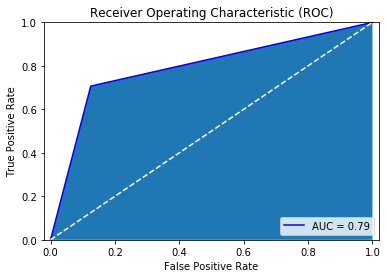

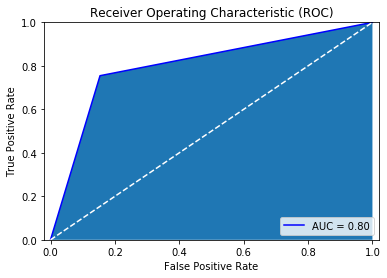

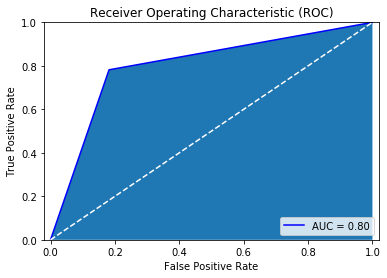

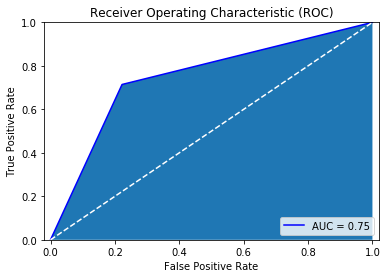

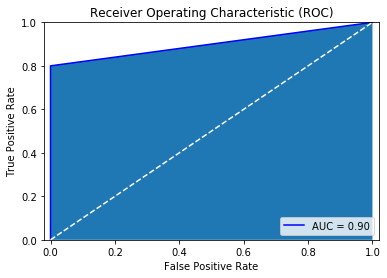

In [112]:
# Cross validation settings
auc_scores = []
confusion_matrixes = []
cv = KFold(n_splits=K_FOLD_NUM_SPLITS, random_state=SEED, shuffle=True)

# CHANGE THIS LINE TO CHANGE THE USED CLASSIFICATION METHOD
classifier = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=2,
                                    max_features='auto', min_samples_leaf=2, min_samples_split=4,
                                    splitter='best', random_state=SEED)

#classifier = RandomForestClassifier(bootstrap=False, class_weight='balanced', criterion='gini',
#                                    max_depth=6, max_features='auto', min_samples_leaf=2,
#                                    min_samples_split=4, n_estimators=8, random_state=SEED)

# Applying sampling techniques
classifier = apply_sampling(classifier, OVERSAMPLE, UNDERSAMPLE)

# Applying Cross validation
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Training with this fold
    classifier.fit(X_train, y_train)
    
    # Testing & Measuring accuracy
    y_pred = classifier.predict(X_test)
    
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
    auc = metrics.auc(fpr, tpr)

    auc_scores.append(auc)
    confusion_matrixes.append(metrics.confusion_matrix(y_test, y_pred).ravel())

    plot_roc_auc(fpr, tpr, auc)
    
# Visualization of classifier result - if DT or RF
algorithm = classifier.get_params().get('classification')

if isinstance(algorithm, DecisionTreeClassifier):
    visualize_tree(algorithm, 'images/DT')

elif isinstance(algorithm, RandomForestClassifier):
    for index, tree in enumerate(algorithm.estimators_):
        visualize_tree(tree, 'images/RF_' + str(index))

In [113]:
# Printing the obtained results
print('Classification Method used:', classifier, '\n')
print('AUC scores:', auc_scores)
print('> Average: ', sum(auc_scores)/len(auc_scores))
for cf in confusion_matrixes:
    display_confusion_matrix(cf)

Classification Method used: Pipeline(memory=None,
         steps=[('classification',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=2,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=4,
                                        min_weight_fraction_leaf=0.0,
                                        presort=False, random_state=42,
                                        splitter='best'))],
         verbose=False) 

AUC scores: [0.790948275862069, 0.8004354136429608, 0.7999999999999999, 0.746031746031746, 0.9]
> Average:  0.8074830871073552
          	Predic NO	Predic YES
Actual NO 	7        	1         
Actual YES	17       	4

### After having our model trained we shall use the model on the data to be sumitted in the kaggle

In [ ]:
test_dataset =  utils.read_csv_to_df('dataset/test_dataset.csv')
test_dataset = test_dataset.set_index('loan_id')
normalize_df(test_dataset)
display(test_dataset.head())

In [ ]:
# We now remove the Y column with NaNs
test_dataset = test_dataset.iloc[:, 0:STATUS_COL]

display(test_dataset.head())

In [ ]:
final_df = pd.DataFrame()

if USE_PCA:
    # Using train PCA and classifying
    scaler=StandardScaler()
    X_test_scaled=scaler.fit_transform(test_dataset)
    predictions_df = pd.DataFrame(data = pca.transform(X_test_scaled),
                                  index=test_dataset.reset_index()['loan_id'])
    display(predictions_df)

    predictions_df['Predicted'] = classifier.predict(predictions_df)
    final_df = predictions_df.reset_index()\
                    [['loan_id', 'Predicted']]\
                    .rename(columns={
                        'loan_id': 'Id'
                    })
    
else:
    final_df = test_dataset.copy()
    final_df['Predicted'] = classifier.predict(final_df)
    final_df = final_df.reset_index()\
                        [['loan_id', 'Predicted']]\
                        .rename(columns={
                            'loan_id': 'Id'
                        })\
                        .drop_duplicates()

final_df.loc[final_df["Predicted"]== 0.0, "Predicted"] = -1
display(final_df)

In [ ]:
# Outputting predictions to .csv
# CHANGE FILE NAME TO PRESERVE DIFFERENT INSTANCES
utils.write_df_to_csv(final_df, 'predictions', 'prediction.csv')